# Assignment 4 - CNN - FashionMnist


## Notes
(schrijf hier notities op over de code)

20 maart:
* train/val split is 80/20, kunnen dit nog aanpassen
* ik heb een average pool gekozen, kunnen nog proberen met maxpool.
* Geen softmax output, want ik las ergens dat dat niet moet als je een crossentropy gebruikt voor loss
* we moeten nog even precies nagaan of alle output sizes kloppen. Ik heb met comments neergezet wat het zou moeten zijn. Misschien iets van model.summary()?
* basismodel convergeert bij zo'n 84% op validation accuracy bij 10 epochs, maar weet ff niet wanneer we nou precies onze testset gebruiken

(Berber) 21 maart:
* paper: https://www.bhu.ac.in/research_pub/jsr/Volumes/JSR_64_02_2020/51.pdf
" The best result obtained with 128 Batch size, softmax activation function, adam optimizer, 0.25 dropout after each pooling layer, 50 epochs and 2x2 kernel size."


* baseline = LeNet5
* varaint 1 = baseline + smaller kernel size
* variant 2 = var 1 + batchnorm
* variant 3 = var2 + conv layer
* variant 4 = var 3 + dropout


(Berber) 25 maart:
* in rode comments zie je bij elke variant meteen wat en waar iets is aangepast
* mang: model is goed getraind als je validation accuracy stabiel wordt is (convergenxe)
* voor het kijken uberhaupt naar de performance van een model kijk je naar de val accuracy & loss
* Voor de dropout: train acc lager dan val acc omdat tijdens het trainen een x % van de neurons niet meedoet en daardoor op dat moment de accuraccy lager is, echter is het aan het einde van het process (als je alles wel mee zou nemen) als het goed is altijd beter. >> dit vermelden in report dan is het goed (evt met plaatje van val acc hoger dan train acc).
* Over de dropout: beste kiezen (als het nu lager lijkt, de val acc) dan wss bij testen alsnog dat model beter. Dus variant 4 dan 'gewoon' beste model
* als je je model verschillend initialiseert, kan het zijn dat er verschillen in accuracues gaan zitten, maar dat is dan maar zo
* which accuracy to use (best over the epochs or the last one: more moral to just use the last one)

(Berber) 26 maart:
* In deze file staan nu alle 4 de varianten goed.
* ben vast begonnen aan report: https://docs.google.com/document/d/1VpAZHD8QDYgH20VhCXshvp5TBrAVup2vA3VDxZAaRMQ/edit?usp=sharing
* de weights etc van het model zijn opgeslagen maar weet niet of jij die ook erbij ziet bij het delen. Ik heb ze ook gedownload dus zal ze ff in git zetten
* Nu moeten we denk ik alleen nog de choice tasks

### Get data
Laden vd data aan de hand van pytorhc tutorial:
https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

Over de data:
Fashion-MNIST is a dataset of Zalando’s article images consisting of 60,000 training examples and 10,000 test examples. Each example comprises a 28×28 grayscale image and an associated label from one of 10 classes.

In [ ]:
# install packages
!pip install torchvision
!pip install mnist_reader
!pip install torchsummary

In [ ]:
import numpy as np
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch import nn
from torchsummary import summary
import random

In [ ]:
# set seed for reproducibility
torch.manual_seed(12) # voor torch
random.seed(12) # for other py functions


In [ ]:
# import data (from pytorch site)
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor() # MOET HIERONDER NIET OOK TARGET_TRANSFORM BIJ OM LABELS NAAR ONE-HOT TE DOEN?
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)



In [ ]:
from torch.utils.data import DataLoader

# divide into train and validation sets
fraction_train = 0.8
total_samples = len(training_data)
train_size = int(fraction_train * total_samples)
validation_size = total_samples - train_size
train_dataset, val_dataset = torch.utils.data.random_split(training_data, [train_size, validation_size])

# prep data for training, validation and testing
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [ ]:
images, labels = next(iter(train_dataloader))
print('shape of batch of images:', images.shape)

shape of batch of images: torch.Size([32, 1, 28, 28])


## Visualisation

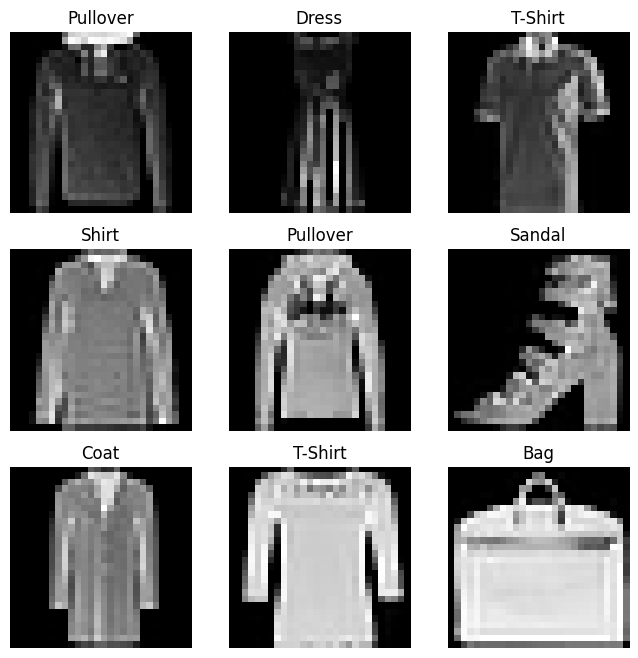

In [ ]:
# example visualisation
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


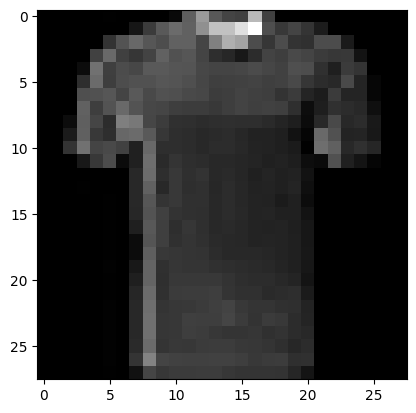

Label: 0


In [ ]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

## Build LeNet5

van tutorial: https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html

Plaatje hieronder gebruikt images van 32x32, wij hebben 28x28


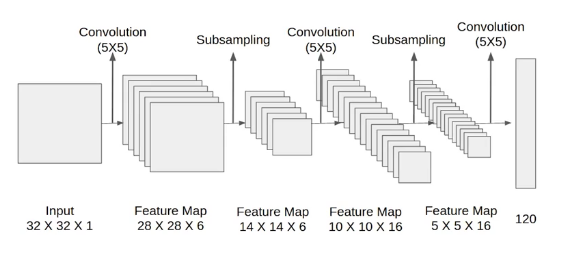

### Baseline LeNet5

class = LeNet5

model = model_baseline

avgPool als baseline gebruikt


Epoch 12
-------------------------------
Train Loss: 0.1680, Accuracy: 93.70%

Validation Loss: 0.2672, Accuracy: 90.78%

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class LeNet5(nn.Module):
    def __init__(self):
        super().__init__()

        # eerste convolutional layer: in_channels is 1, omdat het grayscale is. out_channels is 6, voor 6 filters
        # output size: 28x28x6
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2), # padding of 2 to accomodate for the different input image size
            nn.ReLU())

        # average pool layer / subsampling
        # output size: 14x14x6
        self.avg_pool1 =  nn.AvgPool2d(kernel_size=2, stride=2)

        # tweede convolutional layer, 16 filters
        # output size: 10 x 10 x 16
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0),
            nn.ReLU())

        # output size: 5 x 5 x 16
        self.avg_pool2 =  nn.AvgPool2d(kernel_size=2, stride=2)

        # fully connected layer 1: output 120 feature maps
        self.ful_conn1 = nn.Sequential(
            nn.Linear(in_features=5*5*16, out_features=120),
            nn.ReLU())

        # Fully connected layer 2
        self.ful_conn2 = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.ReLU())

        # final output: 10 classes, no softmax apparently (since the loss func does that automatically????)
        self.ful_conn3 = nn.Linear(84, 10)

    def _reset_parameters(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, nonlinearity='relu') # for initializing the weights
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        out = self.layer1(x)
        out = self.avg_pool1(out)
        out = self.layer3(out)
        out = self.avg_pool2(out)
        out = out.view(out.size(0), -1)  # Flatten
        out = self.ful_conn1(out)
        out = self.ful_conn2(out)
        out = self.ful_conn3(out)
        return out


In [ ]:
def train(dataloader, model, loss_func, optimizer):
    # set to train mode
    model.train()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, correct = 0, 0

    for batch, (X, y) in enumerate(dataloader):

        # prediction and loss > forqard pass
        pred = model(X)
        loss = loss_func(pred, y)

        # backprop
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    train_loss /= num_batches
    correct /= size
    return train_loss, 100 * correct


def val(dataloader, model, loss_func):
    # set to evaluate instead of train
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    val_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            val_loss += loss_func(pred, y).item() #get loss over validation set
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    val_loss /= num_batches
    correct /= size
    return val_loss, 100 * correct

def plot_performance(train_losses, val_losses, train_accuracies, val_accuracies):
    """Plot the training and validation loss and accuracy."""
    plt.figure(figsize=(12, 5))

    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss over Epochs')

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title('Accuracy over Epochs')

    plt.tight_layout()
    plt.show()

Epoch 1
-------------------------------
Train Loss: 0.5250, Accuracy: 80.95%
Validation Loss: 0.4164, Accuracy: 84.56%
Epoch 2
-------------------------------
Train Loss: 0.3610, Accuracy: 86.98%
Validation Loss: 0.3534, Accuracy: 86.96%
Epoch 3
-------------------------------
Train Loss: 0.3127, Accuracy: 88.50%
Validation Loss: 0.3266, Accuracy: 88.01%
Epoch 4
-------------------------------
Train Loss: 0.2825, Accuracy: 89.57%
Validation Loss: 0.2855, Accuracy: 89.65%
Epoch 5
-------------------------------
Train Loss: 0.2615, Accuracy: 90.28%
Validation Loss: 0.2841, Accuracy: 89.53%
Epoch 6
-------------------------------
Train Loss: 0.2424, Accuracy: 91.03%
Validation Loss: 0.2731, Accuracy: 90.13%
Epoch 7
-------------------------------
Train Loss: 0.2290, Accuracy: 91.41%
Validation Loss: 0.2634, Accuracy: 90.68%
Epoch 8
-------------------------------
Train Loss: 0.2135, Accuracy: 92.05%
Validation Loss: 0.2643, Accuracy: 90.52%
Epoch 9
-------------------------------
Train Lo

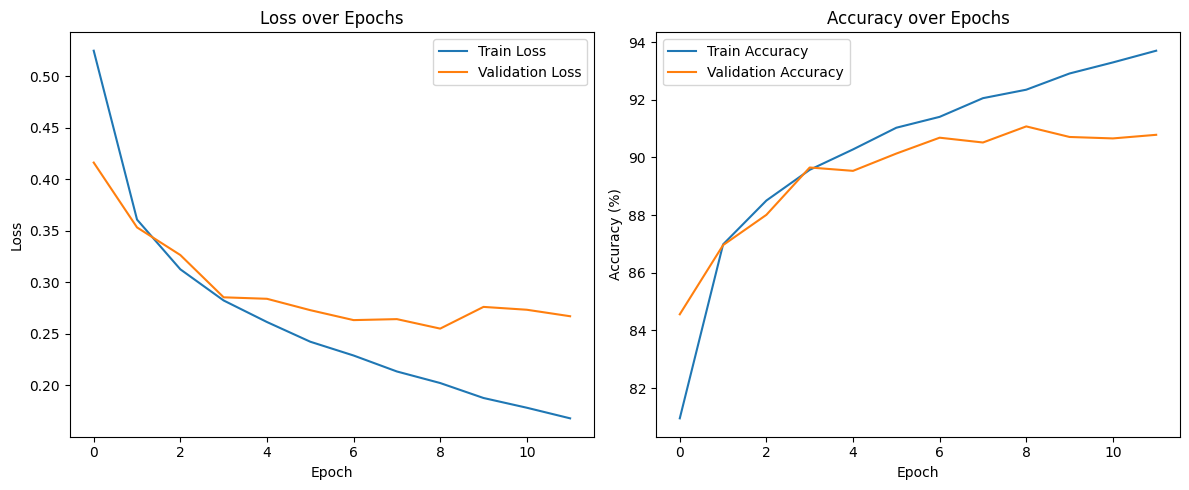

Model parameters and weights saved as 'model_weights_baseline.pth'.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
              ReLU-2            [-1, 6, 28, 28]               0
         AvgPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
              ReLU-5           [-1, 16, 10, 10]               0
         AvgPool2d-6             [-1, 16, 5, 5]               0
            Linear-7                  [-1, 120]          48,120
              ReLU-8                  [-1, 120]               0
            Linear-9                   [-1, 84]          10,164
             ReLU-10                   [-1, 84]               0
           Linear-11                   [-1, 10]             850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
-----------------------------

In [ ]:
# voor baseline
model_baseline = LeNet5()
model_baseline._reset_parameters()

learning_rate = 1e-3  #0.001
loss_func = nn.CrossEntropyLoss() # cross entropy loss
#optimizer = torch.optim.SGD(model_baseline.parameters(), lr=learning_rate) # is dit adam optimizer?
optimizer = torch.optim.Adam(model_baseline.parameters(), lr=learning_rate)
epochs = 12

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss, train_accuracy = train(train_dataloader, model_baseline, loss_func, optimizer)
    val_loss, val_accuracy = val(val_dataloader, model_baseline, loss_func)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    print(f"Train Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%")
    print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2f}%")
print("Done!")

# Plott performance (loss en acc, loss hoeft alleen voor opdracht)
plot_performance(train_losses, val_losses, train_accuracies, val_accuracies)

# Saving model params
torch.save(model_baseline.state_dict(), 'model_weights_baseline.pth')
print("Model parameters and weights saved as 'model_weights_baseline.pth'.")

summary(model_baseline, input_size=(1, 28, 28))

### Variant 1: smaller kernel size

reden: want meer details nodig (vb t-shirt conf mat)

modl: LeNet5_smallKernel

Output size berekenen:

((Input Width - Kernel size + 2*Padding)/stride)+1


Epoch 12
-------------------------------
Train Loss: 0.1564, Accuracy: 94.23%

Validation Loss: 0.2616, Accuracy: 91.24%

In [ ]:
class LeNet5_smallKernel(nn.Module):
    def __init__(self):
        super().__init__()

        """ Smaller Kernel size """
        # First convolutional layer: using a smaller kernel size (3x3) to capture finer details.
        # Adjusted padding to 1 to maintain output size of 28x28x6.
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, stride=1, padding=1),
            nn.ReLU())

        # Average pool layer / subsampling,
        # output size remains 14x14x6.
        self.avg_pool1 = nn.AvgPool2d(kernel_size=2, stride=2)

        """ Smaller Kernel size """
        # Second convolutional layer, using 3x3 kernels , 16 filters
        # Adjusted padding to maintain the intended output size dimensions. >> kan niet? Dan moet padding -1 zijn?
        # output size NEW: 12x12x16 (was 10x10x16 met kernel size 5 en padding=0)
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, stride=1, padding=0),
            nn.ReLU())

        # Adjusting the average pooling to accommodate changes in feature map size,
        # output size: 6x6x16. (BERBER): is het erg dat dit even is? Eeerst was het 5x5
        self.avg_pool2 = nn.AvgPool2d(kernel_size=2, stride=2)

        # fully connected layer 1: output 120 feature maps
        # new input (want aangepast): dus input 6x6x120
        # output = 120 feeature maps
        self.ful_conn1 = nn.Sequential(
            nn.Linear(in_features=6*6*16, out_features=120),
            nn.ReLU())

        # Fully connected layer 2
        # output = 84 features
        self.ful_conn2 = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.ReLU())

        # final output: 10 classes, no softmax apparently (since the loss func does that automatically????)
        self.ful_conn3 = nn.Linear(84, 10)

    def _reset_parameters(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, nonlinearity='relu') # for initializing the weights
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        out = self.layer1(x)
        out = self.avg_pool1(out)
        out = self.layer3(out)
        out = self.avg_pool2(out)
        out = out.view(out.size(0), -1)  # Flatten
        out = self.ful_conn1(out)
        out = self.ful_conn2(out)
        out = self.ful_conn3(out)
        return out


Epoch 1
-------------------------------
Train Loss: 0.4977, Accuracy: 82.06%
Validation Loss: 0.3740, Accuracy: 86.65%
Epoch 2
-------------------------------
Train Loss: 0.3381, Accuracy: 87.71%
Validation Loss: 0.3159, Accuracy: 88.30%
Epoch 3
-------------------------------
Train Loss: 0.2989, Accuracy: 89.06%
Validation Loss: 0.3155, Accuracy: 88.17%
Epoch 4
-------------------------------
Train Loss: 0.2729, Accuracy: 89.93%
Validation Loss: 0.2790, Accuracy: 89.87%
Epoch 5
-------------------------------
Train Loss: 0.2495, Accuracy: 90.73%
Validation Loss: 0.2982, Accuracy: 89.08%
Epoch 6
-------------------------------
Train Loss: 0.2318, Accuracy: 91.47%
Validation Loss: 0.2716, Accuracy: 90.04%
Epoch 7
-------------------------------
Train Loss: 0.2152, Accuracy: 91.97%
Validation Loss: 0.2812, Accuracy: 89.62%
Epoch 8
-------------------------------
Train Loss: 0.2008, Accuracy: 92.44%
Validation Loss: 0.2586, Accuracy: 90.83%
Epoch 9
-------------------------------
Train Lo

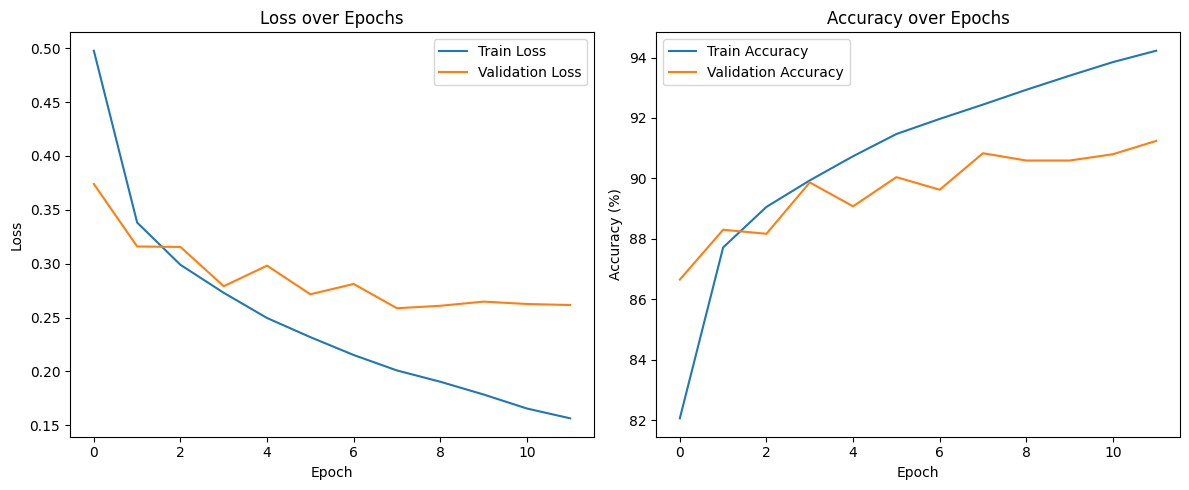

Model parameters and weights saved as 'model_weights_Kernel.pth'.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]              60
              ReLU-2            [-1, 6, 28, 28]               0
         AvgPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 12, 12]             880
              ReLU-5           [-1, 16, 12, 12]               0
         AvgPool2d-6             [-1, 16, 6, 6]               0
            Linear-7                  [-1, 120]          69,240
              ReLU-8                  [-1, 120]               0
            Linear-9                   [-1, 84]          10,164
             ReLU-10                   [-1, 84]               0
           Linear-11                   [-1, 10]             850
Total params: 81,194
Trainable params: 81,194
Non-trainable params: 0
-------------------------------

In [ ]:
model_Kernel = LeNet5_smallKernel()
model_Kernel._reset_parameters()

learning_rate = 1e-3  #0.001
loss_func = nn.CrossEntropyLoss() # cross entropy loss
optimizer = torch.optim.Adam(model_Kernel.parameters(), lr=learning_rate)
epochs = 12

train_losses1, val_losses1 = [], []
train_accuracies1, val_accuracies1 = [], []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss1, train_accuracy1 = train(train_dataloader, model_Kernel, loss_func, optimizer)
    val_loss1, val_accuracy1 = val(val_dataloader, model_Kernel, loss_func)
    train_losses1.append(train_loss1)
    val_losses1.append(val_loss1)
    train_accuracies1.append(train_accuracy1)
    val_accuracies1.append(val_accuracy1)
    print(f"Train Loss: {train_loss1:.4f}, Accuracy: {train_accuracy1:.2f}%")
    print(f"Validation Loss: {val_loss1:.4f}, Accuracy: {val_accuracy1:.2f}%")
print("Done!")

# Plott performance (loss en acc, loss hoeft alleen voor opdracht)
plot_performance(train_losses1, val_losses1, train_accuracies1, val_accuracies1)

# Saving model params
torch.save(model_Kernel.state_dict(), 'model_weights_Kernel.pth')
print("Model parameters and weights saved as 'model_weights_Kernel.pth'.")


summary(model_Kernel, input_size=(1, 28, 28))


### Variant 2 : var1 + batchnorm

Doet: adds a scaling param and a translation param

Batchnorm toegevoegd in de conv layers

Epoch 12
-------------------------------
Train Loss: 0.1365, Accuracy: 94.90%

Validation Loss: 0.2589, Accuracy: 91.45%


In [ ]:
class LeNet5_BatchNorm(nn.Module):
    def __init__(self):
        super().__init__()

        """ Batcnorm toegevoegd """
        # First convolutional layer: using a smaller kernel size (3x3) to capture finer details.
        # Adjusted padding to 1 to maintain output size of 28x28x6.
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(6), # add batchNorm, 6 features
            nn.ReLU())

        # Average pool layer / subsampling,
        # output size remains 14x14x6.
        self.avg_pool1 = nn.AvgPool2d(kernel_size=2, stride=2)

        """ BatchNorm toegevoegd """
        # Second convolutional layer, using 3x3 kernels , 16 filters
        # Adjusted padding to maintain the intended output size dimensions. >> kan niet? Dan moet padding -1 zijn?
        # output size NEW: 12x12x16 (was 10x10x16 met kernel size 5 en padding=0)
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(16), # add batchNorm, 16 features
            nn.ReLU())

        # Adjusting the average pooling to accommodate changes in feature map size,
        # output size: 6x6x16. (BERBER): is het erg dat dit even is? Eeerst was het 5x5
        self.avg_pool2 = nn.AvgPool2d(kernel_size=2, stride=2)

        # fully connected layer 1: output 120 feature maps
        # new input (want aangepast): dus input 6x6x120
        # output = 120 feeature maps
        self.ful_conn1 = nn.Sequential(
            nn.Linear(in_features=6*6*16, out_features=120),
            nn.ReLU())

        # Fully connected layer 2
        # output = 84 features
        self.ful_conn2 = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.ReLU())

        # final output: 10 classes, no softmax apparently (since the loss func does that automatically????)
        self.ful_conn3 = nn.Linear(84, 10)

    def _reset_parameters(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, nonlinearity='relu') # for initializing the weights
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        out = self.layer1(x)
        out = self.avg_pool1(out)
        out = self.layer3(out)
        out = self.avg_pool2(out)
        out = out.view(out.size(0), -1)  # Flatten
        out = self.ful_conn1(out)
        out = self.ful_conn2(out)
        out = self.ful_conn3(out)
        return out


Epoch 1
-------------------------------
Train Loss: 0.4401, Accuracy: 83.98%
Validation Loss: 0.3608, Accuracy: 86.76%
Epoch 2
-------------------------------
Train Loss: 0.3107, Accuracy: 88.65%
Validation Loss: 0.3158, Accuracy: 88.25%
Epoch 3
-------------------------------
Train Loss: 0.2710, Accuracy: 90.15%
Validation Loss: 0.2775, Accuracy: 89.53%
Epoch 4
-------------------------------
Train Loss: 0.2449, Accuracy: 91.03%
Validation Loss: 0.2548, Accuracy: 90.36%
Epoch 5
-------------------------------
Train Loss: 0.2239, Accuracy: 91.60%
Validation Loss: 0.2573, Accuracy: 90.28%
Epoch 6
-------------------------------
Train Loss: 0.2090, Accuracy: 92.11%
Validation Loss: 0.2461, Accuracy: 90.93%
Epoch 7
-------------------------------
Train Loss: 0.1932, Accuracy: 92.83%
Validation Loss: 0.2557, Accuracy: 90.88%
Epoch 8
-------------------------------
Train Loss: 0.1790, Accuracy: 93.32%
Validation Loss: 0.2443, Accuracy: 91.34%
Epoch 9
-------------------------------
Train Lo

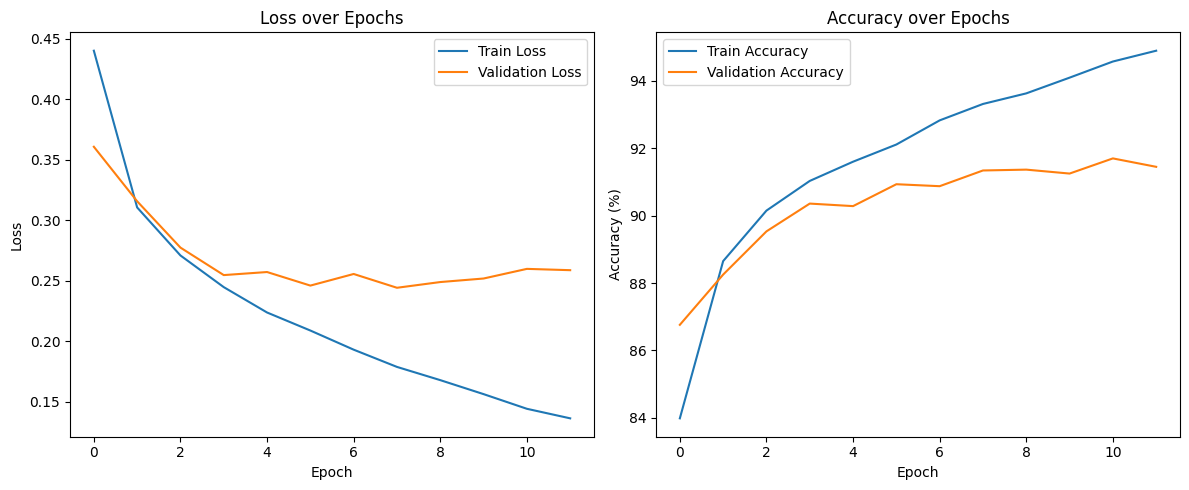

Model parameters and weights saved as 'model_weights_batch.pth'.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]              60
       BatchNorm2d-2            [-1, 6, 28, 28]              12
              ReLU-3            [-1, 6, 28, 28]               0
         AvgPool2d-4            [-1, 6, 14, 14]               0
            Conv2d-5           [-1, 16, 12, 12]             880
       BatchNorm2d-6           [-1, 16, 12, 12]              32
              ReLU-7           [-1, 16, 12, 12]               0
         AvgPool2d-8             [-1, 16, 6, 6]               0
            Linear-9                  [-1, 120]          69,240
             ReLU-10                  [-1, 120]               0
           Linear-11                   [-1, 84]          10,164
             ReLU-12                   [-1, 84]               0
           Linear-13                  

In [ ]:
model_batch = LeNet5_BatchNorm()
model_batch._reset_parameters()

learning_rate = 1e-3  #0.001
loss_func = nn.CrossEntropyLoss() # cross entropy loss
optimizer = torch.optim.Adam(model_batch.parameters(), lr=learning_rate)
epochs = 12

train_losses2, val_losses2 = [], []
train_accuracies2, val_accuracies2 = [], []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss2, train_accuracy2 = train(train_dataloader, model_batch, loss_func, optimizer)
    val_loss2, val_accuracy2 = val(val_dataloader, model_batch, loss_func)
    train_losses2.append(train_loss2)
    val_losses2.append(val_loss2)
    train_accuracies2.append(train_accuracy2)
    val_accuracies2.append(val_accuracy2)
    print(f"Train Loss: {train_loss2:.4f}, Accuracy: {train_accuracy2:.2f}%")
    print(f"Validation Loss: {val_loss2:.4f}, Accuracy: {val_accuracy2:.2f}%")
print("Done!")

# Plott performance (loss en acc, loss hoeft alleen voor opdracht)
plot_performance(train_losses2, val_losses2, train_accuracies2, val_accuracies2)

# Saving model params
torch.save(model_batch.state_dict(), 'model_weights_batch.pth')
print("Model parameters and weights saved as 'model_weights_batch.pth'.")

summary(model_batch, input_size=(1, 28, 28))


### Variant 3: variant 2 + change in filter size

moet nog ff bedenken waarom obv vorige variant maar in paper deden ze dit ook
&& accuracy gaat omhoog

Epoch 12
-------------------------------
Train Loss: 0.0975, Accuracy: 96.27%

Validation Loss: 0.2589, Accuracy: 92.35%

In [ ]:
# filter size 64 is 32 min om te runnen
# 32 is 14 min om te runnn
class LeNet5_Filter(nn.Module):
    def __init__(self):
        super().__init__()

        """ adjust filter size """
        # First convolutional layer: using a smaller kernel size (3x3) to capture finer details.
        # Adjusted padding to 1 to maintain output size of 28x28x6.
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32), # add batchNorm, 6 features
            nn.ReLU())

        # Average pool layer / subsampling,
        # output size remains 14x14x6.
        self.avg_pool1 = nn.AvgPool2d(kernel_size=2, stride=2)

        """ adjust filter size """
        # Second convolutional layer, using 3x3 kernels , 16 filters
        # Adjusted padding to maintain the intended output size dimensions. >> kan niet? Dan moet padding -1 zijn?
        # output size NEW: 12x12x16 (was 10x10x16 met kernel size 5 en padding=0)
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(32), # add batchNorm, 16 features
            nn.ReLU())

        # Adjusting the average pooling to accommodate changes in feature map size,
        # output size: 6x6x16. (BERBER): is het erg dat dit even is? Eeerst was het 5x5
        self.avg_pool2 = nn.AvgPool2d(kernel_size=2, stride=2)

        """ adjust filter size """
        # fully connected layer 1: output 120 feature maps
        # new input (want aangepast): dus input 6x6x120
        # output = 120 feeature maps
        self.ful_conn1 = nn.Sequential(
            nn.Linear(in_features=6*6*32, out_features=120),
            nn.ReLU())

        # Fully connected layer 2
        # output = 84 features
        self.ful_conn2 = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.ReLU())

        # final output: 10 classes, no softmax apparently (since the loss func does that automatically????)
        self.ful_conn3 = nn.Linear(84, 10)

    def _reset_parameters(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, nonlinearity='relu') # for initializing the weights
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        out = self.layer1(x)
        out = self.avg_pool1(out)
        out = self.layer3(out)
        out = self.avg_pool2(out)
        out = out.view(out.size(0), -1)  # Flatten
        out = self.ful_conn1(out)
        out = self.ful_conn2(out)
        out = self.ful_conn3(out)
        return out


Epoch 1
-------------------------------
Train Loss: 0.4216, Accuracy: 84.45%
Validation Loss: 0.3740, Accuracy: 86.65%
Epoch 2
-------------------------------
Train Loss: 0.2855, Accuracy: 89.54%
Validation Loss: 0.3105, Accuracy: 89.11%
Epoch 3
-------------------------------
Train Loss: 0.2430, Accuracy: 90.94%
Validation Loss: 0.2696, Accuracy: 90.18%
Epoch 4
-------------------------------
Train Loss: 0.2158, Accuracy: 92.00%
Validation Loss: 0.2673, Accuracy: 90.16%
Epoch 5
-------------------------------
Train Loss: 0.1922, Accuracy: 92.81%
Validation Loss: 0.2315, Accuracy: 91.65%
Epoch 6
-------------------------------
Train Loss: 0.1748, Accuracy: 93.43%
Validation Loss: 0.2395, Accuracy: 91.57%
Epoch 7
-------------------------------
Train Loss: 0.1591, Accuracy: 94.03%
Validation Loss: 0.2412, Accuracy: 91.69%
Epoch 8
-------------------------------
Train Loss: 0.1441, Accuracy: 94.69%
Validation Loss: 0.2224, Accuracy: 92.22%
Epoch 9
-------------------------------
Train Lo

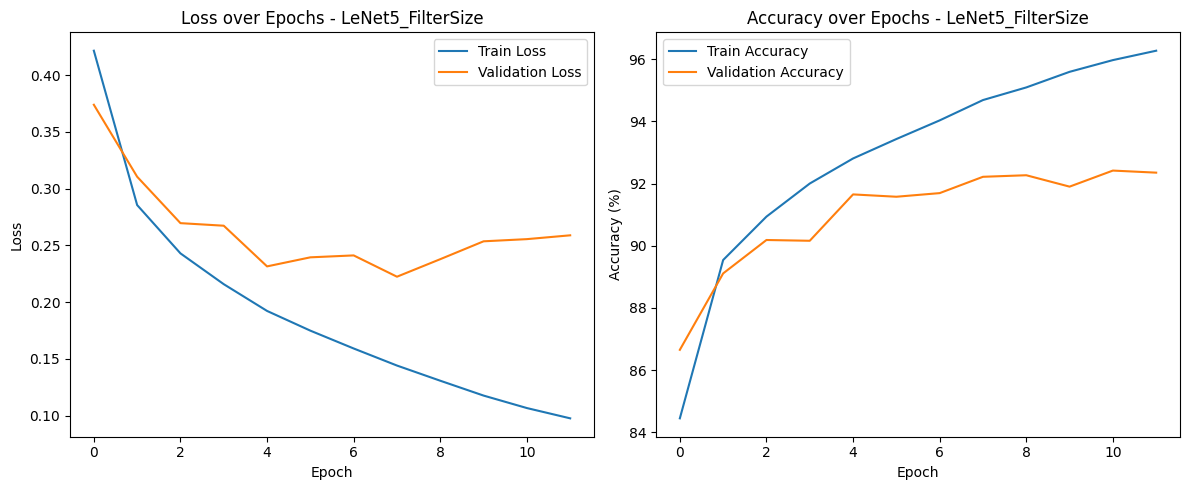

Model parameters and weights saved as 'model_weights_FC.pth'.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
       BatchNorm2d-2           [-1, 32, 28, 28]              64
              ReLU-3           [-1, 32, 28, 28]               0
         AvgPool2d-4           [-1, 32, 14, 14]               0
            Conv2d-5           [-1, 32, 12, 12]           9,248
       BatchNorm2d-6           [-1, 32, 12, 12]              64
              ReLU-7           [-1, 32, 12, 12]               0
         AvgPool2d-8             [-1, 32, 6, 6]               0
            Linear-9                  [-1, 120]         138,360
             ReLU-10                  [-1, 120]               0
           Linear-11                   [-1, 84]          10,164
             ReLU-12                   [-1, 84]               0
           Linear-13                   [-

In [ ]:
model_FilterSize = LeNet5_Filter()
model_FilterSize._reset_parameters()

learning_rate = 1e-3  #0.001
loss_func = nn.CrossEntropyLoss() # cross entropy loss
optimizer = torch.optim.Adam(model_FilterSize.parameters(), lr=learning_rate)
epochs = 12

train_losses33, val_losses33 = [], []
train_accuracies33, val_accuracies33 = [], []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss33, train_accuracy33 = train(train_dataloader, model_FilterSize, loss_func, optimizer)
    val_loss33, val_accuracy33 = val(val_dataloader, model_FilterSize, loss_func)
    train_losses33.append(train_loss33)
    val_losses33.append(val_loss33)
    train_accuracies33.append(train_accuracy33)
    val_accuracies33.append(val_accuracy33)
    print(f"Train Loss: {train_loss33:.4f}, Accuracy: {train_accuracy33:.2f}%")
    print(f"Validation Loss: {val_loss33:.4f}, Accuracy: {val_accuracy33:.2f}%")
print("Done!")


def plot_performance(train_losses, val_losses, train_accuracies, val_accuracies):
    """Plot the training and validation loss and accuracy."""
    plt.figure(figsize=(12, 5))

    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss over Epochs - LeNet5_FilterSize')

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title('Accuracy over Epochs - LeNet5_FilterSize')

    plt.tight_layout()
    plt.show()

# Plott performance (loss en acc, loss hoeft alleen voor opdracht)
plot_performance(train_losses33, val_losses33, train_accuracies33, val_accuracies33)

# Saving model params
torch.save(model_FilterSize.state_dict(), 'model_weights_FC.pth')
print("Model parameters and weights saved as 'model_weights_FC.pth'.")

summary(model_FilterSize, input_size=(1, 28, 28))


### Variant 4 = variant 3 + dropout

Tussen de hidden layers >> dus na pool
Kan ook alleen na de laatste pool?
Of alleen FC.

Verschillende dingen geprobeerd >> dropout in FC layers beste

dropout 0.25 gebruiken ze in paper hierboiven

Epoch 12
-------------------------------
Train Loss: 0.1661, Accuracy: 93.93%

Validation Loss: 0.2302, Accuracy: 92.33%

In [ ]:
# verschillende dropouts geprobeerd > beste 0.25 in fc layers
# geprobeerde dropouts: 0.1, 0.15, 0.25, 0.5 , hoe hoger de dropout hoe lager de performance.
# in conv layer lager dan in fc layers
class LeNet5_Dropout(nn.Module):
    def __init__(self):
        super().__init__()

        """ adjust filter size """
        # First convolutional layer: using a smaller kernel size (3x3) to capture finer details.
        # Adjusted padding to 1 to maintain output size of 28x28x6.
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32), # add batchNorm, 32 features
            nn.ReLU())

        # Average pool layer / subsampling,
        # output size remains 14x14x6.
        self.avg_pool1 = nn.AvgPool2d(kernel_size=2, stride=2)

        # Second convolutional layer, using 3x3 kernels , 16 filters
        # Adjusted padding to maintain the intended output size dimensions. >> kan niet? Dan moet padding -1 zijn?
        # output size NEW: 12x12x16 (was 10x10x16 met kernel size 5 en padding=0)
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(32), # add batchNorm, 32 features
            nn.ReLU())

        # Adjusting the average pooling to accommodate changes in feature map size,
        # output size: 6x6x16. (BERBER): is het erg dat dit even is? Eeerst was het 5x5
        self.avg_pool2 = nn.AvgPool2d(kernel_size=2, stride=2)

        " added dropout "
        # fully connected layer 1: output 120 feature maps
        # new input (want aangepast): dus input 6x6x120
        # output = 120 feeature maps
        self.ful_conn1 = nn.Sequential(
            nn.Linear(in_features=6*6*32, out_features=120),
            nn.ReLU(),
            nn.Dropout(0.25)) # add dropout

        " added dropout "
        # Fully connected layer 2
        # output = 84 features
        self.ful_conn2 = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.ReLU(),
            nn.Dropout(0.25)) # add dropout

        # final output: 10 classes, no softmax apparently (since the loss func does that automatically????)
        self.ful_conn3 = nn.Linear(84, 10)

    def _reset_parameters(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, nonlinearity='relu') # for initializing the weights
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        out = self.layer1(x)
        out = self.avg_pool1(out)
        out = self.layer3(out)
        out = self.avg_pool2(out)
        out = out.view(out.size(0), -1)  # Flatten
        out = self.ful_conn1(out)
        out = self.ful_conn2(out)
        out = self.ful_conn3(out)
        return out

Epoch 1
-------------------------------
Train Loss: 0.5446, Accuracy: 80.67%
Validation Loss: 0.3353, Accuracy: 87.62%
Epoch 2
-------------------------------
Train Loss: 0.3565, Accuracy: 87.36%
Validation Loss: 0.3162, Accuracy: 88.88%
Epoch 3
-------------------------------
Train Loss: 0.3078, Accuracy: 89.08%
Validation Loss: 0.2712, Accuracy: 90.12%
Epoch 4
-------------------------------
Train Loss: 0.2744, Accuracy: 90.13%
Validation Loss: 0.2559, Accuracy: 90.85%
Epoch 5
-------------------------------
Train Loss: 0.2518, Accuracy: 90.89%
Validation Loss: 0.2376, Accuracy: 91.43%
Epoch 6
-------------------------------
Train Loss: 0.2335, Accuracy: 91.72%
Validation Loss: 0.2327, Accuracy: 91.56%
Epoch 7
-------------------------------
Train Loss: 0.2203, Accuracy: 92.19%
Validation Loss: 0.2395, Accuracy: 91.19%
Epoch 8
-------------------------------
Train Loss: 0.2044, Accuracy: 92.66%
Validation Loss: 0.2532, Accuracy: 91.23%
Epoch 9
-------------------------------
Train Lo

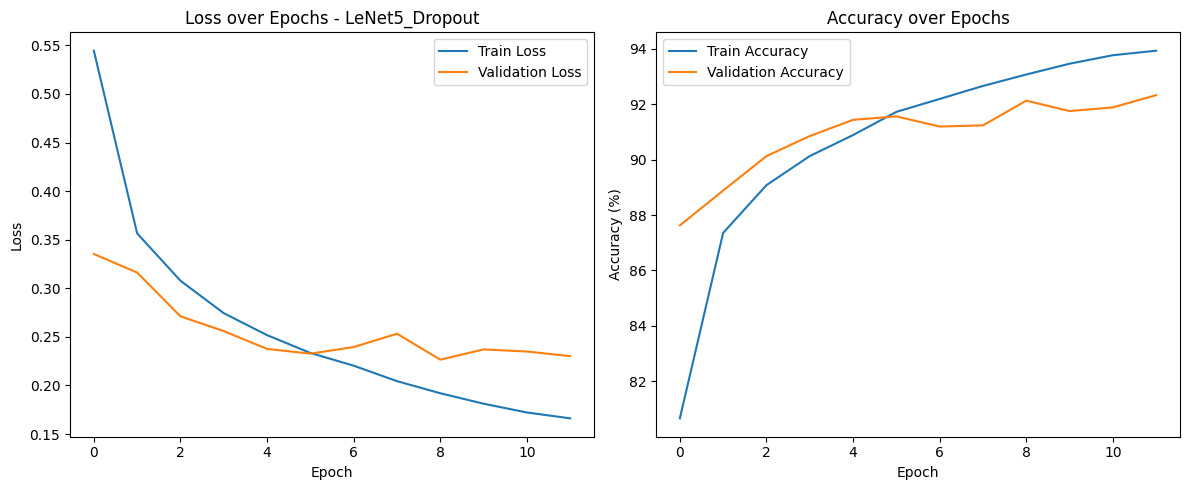

Model parameters and weights saved as 'model_weights_Dropout.pth'.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
       BatchNorm2d-2           [-1, 32, 28, 28]              64
              ReLU-3           [-1, 32, 28, 28]               0
         AvgPool2d-4           [-1, 32, 14, 14]               0
            Conv2d-5           [-1, 32, 12, 12]           9,248
       BatchNorm2d-6           [-1, 32, 12, 12]              64
              ReLU-7           [-1, 32, 12, 12]               0
         AvgPool2d-8             [-1, 32, 6, 6]               0
            Linear-9                  [-1, 120]         138,360
             ReLU-10                  [-1, 120]               0
          Dropout-11                  [-1, 120]               0
           Linear-12                   [-1, 84]          10,164
             ReLU-13                

In [ ]:
model_Dropout = LeNet5_Dropout()
model_Dropout._reset_parameters()

learning_rate = 1e-3  #0.001
loss_func = nn.CrossEntropyLoss() # cross entropy loss
optimizer = torch.optim.Adam(model_Dropout.parameters(), lr=learning_rate)
epochs = 12

train_losses4, val_losses4 = [], []
train_accuracies4, val_accuracies4 = [], []

def plot_performance(train_losses, val_losses, train_accuracies, val_accuracies):
    """Plot the training and validation loss and accuracy."""
    plt.figure(figsize=(12, 5))

    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss over Epochs - LeNet5_Dropout')

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title('Accuracy over Epochs')

    plt.tight_layout()
    plt.show()

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss4, train_accuracy4 = train(train_dataloader, model_Dropout, loss_func, optimizer)
    val_loss4, val_accuracy4 = val(val_dataloader, model_Dropout, loss_func)
    train_losses4.append(train_loss4)
    val_losses4.append(val_loss4)
    train_accuracies4.append(train_accuracy4)
    val_accuracies4.append(val_accuracy4)
    print(f"Train Loss: {train_loss4:.4f}, Accuracy: {train_accuracy4:.2f}%")
    print(f"Validation Loss: {val_loss4:.4f}, Accuracy: {val_accuracy4:.2f}%")
print("Done!")

# Plott performance (loss en acc, loss hoeft alleen voor opdracht)
plot_performance(train_losses4, val_losses4, train_accuracies4, val_accuracies4)

# Saving model params
torch.save(model_Dropout.state_dict(), 'model_weights_Dropout.pth')
print("Model parameters and weights saved as 'model_weights_Dropout.pth'.")

summary(model_Dropout, input_size=(1, 28, 28))